In [1]:
from dynamite_sdk.search import Search
from datetime import datetime, timedelta
from dynamite_sdk.anomaly_detection.gaussian_anomaly_detector import GaussianAnomalyDetector

import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Get the baseline features aggregated at 5 min interval 

In [2]:
start = datetime.now() - timedelta(minutes=1000)
end = datetime.now()

search = Search('baselines', as_dataframe=True)
search.execute_query(start, end)

# for event in search.results:
#     print(event)
search.results.head(2)

,elasticsearch_index,originating_agent_tag,forwarder_type,event_type,node_ip_address,node_hostname,address,start_time,end_time,interval_size,...,ssl_server_connection_count,ssl_producer_consumer_ratio_average,ssl_producer_consumer_ratio_max,ssl_producer_consumer_ratio_min,rdp_client_connection_count,rdp_server_connection_count,rdp_producer_consumer_ratio_average,rdp_producer_consumer_ratio_max,rdp_producer_consumer_ratio_min,external_ports
0,zeek-baselines-2019.12.02,honeypot03,zeek,netbase,54.202.227.137,ip-172-31-7-189,172.31.7.189,2019-12-02 18:31:23.399000+00:00,2019-12-02 18:36:24.705000+00:00,00:05:01.306000,...,0,0,0,0,0,0,0,0,0,0
1,zeek-baselines-2019.12.02,honeypot01,zeek,netbase,192.168.53.158,ip-192-168-53-158.us-west-2.compute.internal,192.168.53.158,2019-12-02 18:30:53.803000+00:00,2019-12-02 18:35:55.628000+00:00,00:05:01.825000,...,0,0,0,0,0,0,0,0,0,0


In [28]:
search.results.columns

Index(['elasticsearch_index', 'originating_agent_tag', 'forwarder_type',
       'event_type', 'node_ip_address', 'node_hostname', 'address',
       'start_time', 'end_time', 'interval_size', 'internal_port_count',
       'internal_host_count', 'external_port_count', 'external_host_count',
       'internal_client_count', 'external_client_count', 'connection_count',
       'originating_connection_count',
       'successful_originating_connection_count',
       'rejected_originating_connection_count',
       'originating_to_highport_count', 'originating_to_lowport_count',
       'originating_to_service_count', 'internal_originating_connection_count',
       'internal_originating_rejected_connection_count',
       'internal_to_highport_count', 'internal_to_lowport_count',
       'internal_to_service_count', 'internal_received_connection_count',
       'internal_originating_bytes_sent_sum',
       'internal_originating_bytes_received_sum',
       'external_originating_bytes_sent_sum',
     


### Select aggregated columns to build Anomaly Detection model

In [4]:
feature_columns = ['internal_port_count', 'internal_host_count',  'external_port_count',  
'external_host_count', 'internal_client_count',  'external_client_count',  'connection_count', 
                   'originating_connection_count', 'successful_originating_connection_count', 
                   'rejected_originating_connection_count', 'originating_to_highport_count',  
                   'originating_to_lowport_count', 'originating_to_service_count',  
                   'internal_originating_connection_count', 'internal_originating_rejected_connection_count', 
                   'internal_to_highport_count',  'internal_to_lowport_count', 'internal_to_service_count',  
                   'internal_received_connection_count', 'internal_originating_bytes_sent_sum', 
                   'internal_originating_bytes_received_sum', 'external_originating_bytes_sent_sum', 
                   'external_originating_bytes_received_sum', 'internal_originating_packets_sent_count', 
                   'internal_originating_packets_received_count', 'external_originating_packets_sent_count', 
                   'external_originating_packets_received_count', 'smb_client_connection_count',  
                   'smb_server_connection_count', 'smb_producer_consumer_ratio_average', 
                   'smb_producer_consumer_ratio_max',  'smb_producer_consumer_ratio_min', 
                   'http_client_connection_count',  'http_server_connection_count', 
                   'http_producer_consumer_ratio_average', 'http_producer_consumer_ratio_max',  
                   'http_producer_consumer_ratio_min', 'dns_client_connection_count',  
                   'dns_server_connection_count', 'dns_producer_consumer_ratio_average', 
                   'dns_producer_consumer_ratio_max',  'dns_producer_consumer_ratio_min', 
                   'ssl_client_connection_count',  'ssl_server_connection_count', 
                   'ssl_producer_consumer_ratio_average', 'ssl_producer_consumer_ratio_max',  
                   'ssl_producer_consumer_ratio_min', 'rdp_client_connection_count',  
                   'rdp_server_connection_count', 'rdp_producer_consumer_ratio_average', 
                   'rdp_producer_consumer_ratio_max',  'rdp_producer_consumer_ratio_min']
features = search.results[feature_columns]

In [5]:
# remove columns that have constant values
# Column with constant values do add value to model and gives invalid results.
train = features.loc[:,features.apply(pd.Series.nunique) != 1]

In [6]:
train.columns

Index(['internal_port_count', 'internal_host_count', 'external_port_count',
       'external_host_count', 'internal_client_count', 'external_client_count',
       'connection_count', 'successful_originating_connection_count',
       'originating_to_lowport_count', 'originating_to_service_count',
       'internal_originating_connection_count', 'internal_to_lowport_count',
       'internal_to_service_count', 'internal_received_connection_count',
       'internal_originating_bytes_sent_sum',
       'internal_originating_bytes_received_sum',
       'external_originating_bytes_sent_sum',
       'external_originating_bytes_received_sum',
       'internal_originating_packets_sent_count',
       'internal_originating_packets_received_count',
       'external_originating_packets_sent_count',
       'external_originating_packets_received_count',
       'http_client_connection_count', 'http_producer_consumer_ratio_average',
       'http_producer_consumer_ratio_max', 'http_producer_consumer_ratio_

In [10]:
# Fit a Gaussian Anomaly Detector
model = GaussianAnomalyDetector(contamination=0.05, log_transform=True)
model.fit(train)

GaussianAnomalyDetector(contamination=0.05, log_transform=True)

In [31]:
# get predictions and reasons from the model
zipped_list = list(zip(search.results.node_ip_address, search.results.start_time, model.predict(train), model.get_reason()))
predictions = pd.DataFrame(zipped_list, columns=['ip', 'start_time', 'prediction', 'reason'])

In [33]:
# display anamolies
predictions[predictions.prediction == 1].head()

,ip,start_time,prediction,reason
148,192.168.53.158,2019-12-02 14:37:51.203000+00:00,1,http_producer_consumer_ratio_max
220,192.168.53.158,2019-12-02 12:38:34.586000+00:00,1,http_producer_consumer_ratio_max
225,192.168.53.158,2019-12-02 12:33:25.018000+00:00,1,dns_client_connection_count
243,192.168.53.158,2019-12-02 12:07:35.720000+00:00,1,dns_client_connection_count
261,192.168.53.158,2019-12-02 11:42:04.665000+00:00,1,dns_client_connection_count


In [40]:
count_preds = predictions[['ip', 'prediction']].groupby('ip').sum()

count_preds.reset_index(inplace=True)

count_preds.columns = ['ip', 'anomalous_count']

### Bar plot (Y-axis count of anomlies for a given IP, X-axis the IPs) 

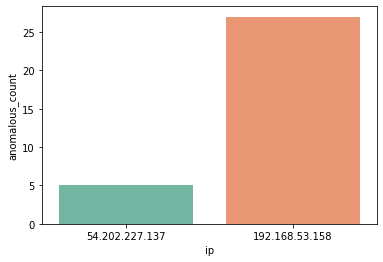

In [49]:
sns.set_palette(sns.color_palette("Set2"))
sns.barplot(count_preds.ip, count_preds.anomalous_count)